FIRST AND MOST IMPORTANT WE HAVE TO SEE DATASET WHAT OUR DATA IS 



In [1]:
import pandas as pd
import time
import os
import numpy as np

In [2]:
df=pd.read_excel("/Users/harshkarnani/Desktop/ai_lab/Worksheet in Predicting Energy Consumption.xlsm")

seeing how our data is coloums name and information about data summary statics and null values

In [3]:
print(df.head())
print(df.columns)
print(df.info())



       Start time UTC        End time UTC  Electricity consumption (MWh)
0 2015-12-31 21:00:00 2015-12-31 22:00:00                          10800
1 2015-12-31 22:00:00 2015-12-31 23:00:00                          10431
2 2015-12-31 23:00:00 2016-01-01 00:00:00                          10005
3 2016-01-01 00:00:00 2016-01-01 01:00:00                           9722
4 2016-01-01 01:00:00 2016-01-01 02:00:00                           9599
Index(['Start time UTC', 'End time UTC', 'Electricity consumption (MWh)'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52966 entries, 0 to 52965
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Start time UTC                 52966 non-null  datetime64[ns]
 1   End time UTC                   52966 non-null  datetime64[ns]
 2   Electricity consumption (MWh)  52966 non-null  int64         
dtypes: datetime64[ns](2), i

as we can see we have 3 coloums and 2 contatin time so we have to treat them as date and time series the colum name has gaps giving issue so we have to rename or strip it and then we have to convert it to time series


In [4]:
#s we can see we have 3 coloums and 2 contatin time so we have to treat them as date and time series the colum name has gaps giving issue so we have to rename or strip it and then we have to convert it to time series
df.columns=df.columns.str.strip()
df.columns=df.columns.str.replace(" ","_")
df.columns
df["Start_time_UTC"] = pd.to_datetime(df["Start_time_UTC"], utc=False)
df["End_time_UTC"]   = pd.to_datetime(df["End_time_UTC"], utc=False)

print(df.dtypes)


Start_time_UTC                   datetime64[ns]
End_time_UTC                     datetime64[ns]
Electricity_consumption_(MWh)             int64
dtype: object


now after reasling all that sorting and seeing that its can be assured that its consumption every hours
now we have to look for null and duplicate values


In [5]:
print(df["Start_time_UTC"].min(), df["Start_time_UTC"].max())
print(df["End_time_UTC"].min(), df["End_time_UTC"].max())
print(df["Start_time_UTC"].isnull().sum())
print(df["End_time_UTC"].isnull().sum())
print(df["End_time_UTC"].duplicated().sum())
print(df["Start_time_UTC"].duplicated().sum())

2015-12-31 21:00:00 2021-12-31 20:00:00
2015-12-31 22:00:00 2021-12-31 21:00:00
0
0
0
0


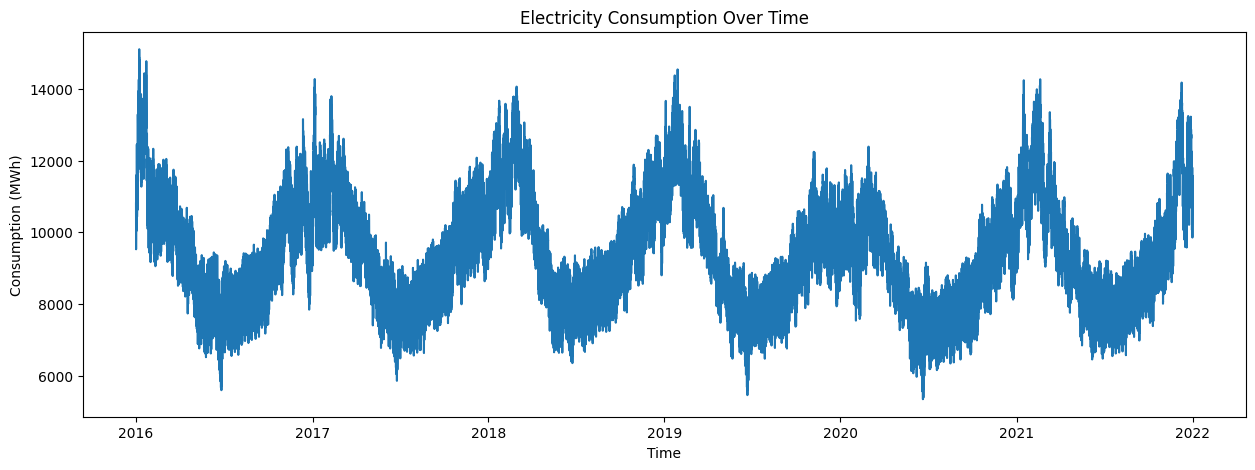

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,5))
plt.plot(df["Start_time_UTC"], df["Electricity_consumption_(MWh)"])
plt.title("Electricity Consumption Over Time")
plt.xlabel("Time")
plt.ylabel("Consumption (MWh)")
plt.show()

## Sources
- [India Meteorological Department (IMD)](https://mausam.imd.gov.in)
- [Our World in Data: Energy](https://ourworldindata.org/energy)

## Key Understanding for Trend Analysis
From these sources, a few demand spikes (outliers) appear to be **real-world effects**, not data errors.

> If it is summer season, electricity consumption is higher.  
> During festival season, consumption increases.  
> During extreme cold, consumption is more.

So, these outliers should **not** be blindly removed.  
Removing them may introduce bias and produce false sampling.

## Important Factors to Analyze

- **Time of day**
  - Night: low
  - Morning: increasing
  - Evening: peak

- **Day type**
  - Weekdays: higher (offices, factories)
  - Weekends: lower

- **Season**
  - Summer: high (AC)
  - Winter: heating (depends on region)

- **Special events**
  - Festivals
  - Holidays
  - Heat waves

## important features which can affect it
- weekend
- day of week
- month year and holidays
- Previous hour
- Same hour yesterday
- Same hour last week

and last but not the least they treat number as number what it means that they treat 0 as 0 and 23 as 23 mean 0 < 23 but hourly its not correct so we have do  
treating them ordinal but ann can create biaseness due to ordinal but tress dosent  
use one hot but it always came with curse of dimmension incremental  
so best option is use sin/cos encoding treated as cylic


In [7]:

df = df.sort_values('Start_time_UTC')

# Extract time features
df['hour'] = df['Start_time_UTC'].dt.hour
df['dayofweek'] = df['Start_time_UTC'].dt.dayofweek
df['month'] = df['Start_time_UTC'].dt.month
df['dayofyear'] = df['Start_time_UTC'].dt.dayofyear
df['weekofyear'] = df['Start_time_UTC'].dt.isocalendar().week.astype(int)
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

In [8]:
# Hour cyclical
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

# Day of week cyclical
df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek']/7)
df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek']/7)

# Month cyclical
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

In [9]:
# Target column
target = 'Electricity_consumption_(MWh)'

# Lag features
df['one_hour_ago'] = df[target].shift(1)
df['one_day_ago'] = df[target].shift(24)
df['one_week_ago'] = df[target].shift(168)  # previous week same hour

 we are dropping 168 rows which way look that much but its 
-6 years × 365 days × 24 hours ≈ 52,560 rows
--168 / 52560 ≈ 0.0032 = 0.32%
-Change mean significantly
-Change variance significantly
-Affect distribution shape

In [10]:
df.dropna(inplace=False)

,Start_time_UTC,End_time_UTC,Electricity_consumption_(MWh),hour,dayofweek,month,dayofyear,weekofyear,is_weekend,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos,one_hour_ago,one_day_ago,one_week_ago
168,2016-01-07 21:00:00,2016-01-07 22:00:00,14074,21,3,1,7,1,0,-0.707107,7.071068e-01,0.433884,-0.900969,5.000000e-01,0.866025,14303.0,13672.0,10800.0
169,2016-01-07 22:00:00,2016-01-07 23:00:00,13643,22,3,1,7,1,0,-0.500000,8.660254e-01,0.433884,-0.900969,5.000000e-01,0.866025,14074.0,13285.0,10431.0
170,2016-01-07 23:00:00,2016-01-08 00:00:00,13369,23,3,1,7,1,0,-0.258819,9.659258e-01,0.433884,-0.900969,5.000000e-01,0.866025,13643.0,13011.0,10005.0
171,2016-01-08 00:00:00,2016-01-08 01:00:00,13142,0,4,1,8,1,0,0.000000,1.000000e+00,-0.433884,-0.900969,5.000000e-01,0.866025,13369.0,12821.0,9722.0
172,2016-01-08 01:00:00,2016-01-08 02:00:00,13111,1,4,1,8,1,0,0.258819,9.659258e-01,-0.433884,-0.900969,5.000000e-01,0.866025,13142.0,12821.0,9599.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52961,2021-12-31 16:00:00,2021-12-31 17:00:00,11447,16,4,12,365,52,0,-0.866025,-5.000000e-01,-0.433884,-0.900969,-2.449294e-16,1.000000,11575.0,11763.0,11902.0
52962,2021-12-31 17:00:00,2021-12-31 18:00:00,11237,17,4,12,365,52,0,-0.965926,-2.588190e-01,-0.433884,-0.900969,-2.449294e-16,1.000000,11447.0,11747.0,11798.0
52963,2021-12-31 18:00:00,2021-12-31 19:00:00,10914,18,4,12,365,52,0,-1.000000,-1.836970e-16,-0.433884,-0.900969,-2.449294e-16,1.000000,11237.0,11581.0,11705.0
52964,2021-12-31 19:00:00,2021-12-31 20:00:00,10599,19,4,12,365,52,0,-0.965926,2.588190e-01,-0.433884,-0.900969,-2.449294e-16,1.000000,10914.0,11077.0,11534.0


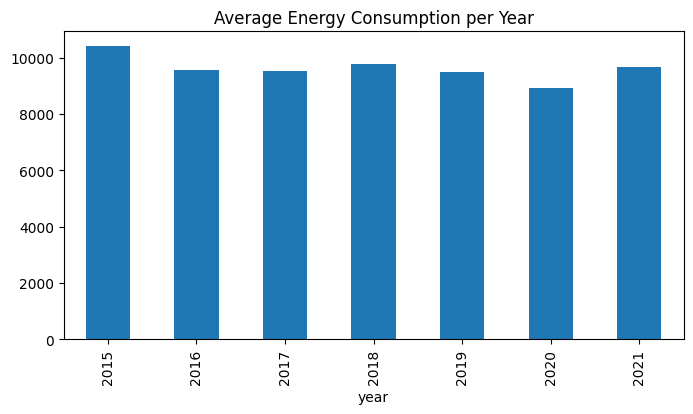

In [11]:
df['year'] = df['Start_time_UTC'].dt.year

yearly = df.groupby('year')['Electricity_consumption_(MWh)'].mean()

yearly.plot(kind='bar', figsize=(8,4))
plt.title("Average Energy Consumption per Year")
plt.show()

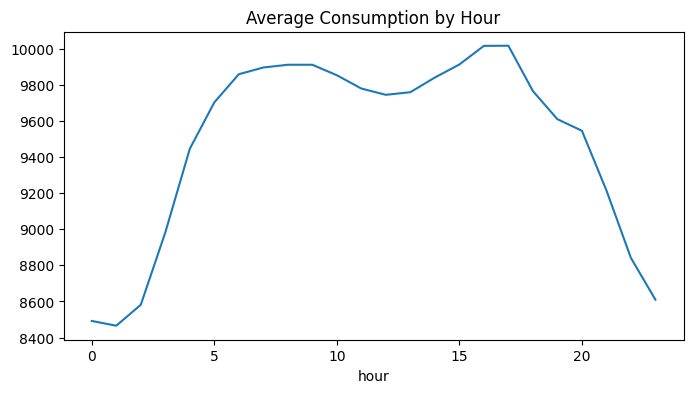

In [12]:
hourly = df.groupby('hour')['Electricity_consumption_(MWh)'].mean()

hourly.plot(figsize=(8,4))
plt.title("Average Consumption by Hour")
plt.show()

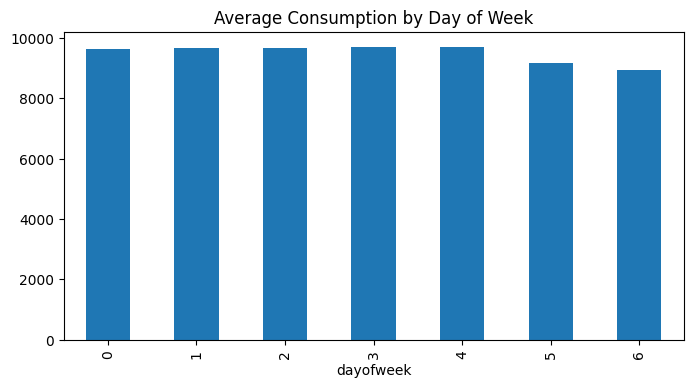

In [13]:
weekly = df.groupby('dayofweek')['Electricity_consumption_(MWh)'].mean()

weekly.plot(kind='bar', figsize=(8,4))
plt.title("Average Consumption by Day of Week")
plt.show()

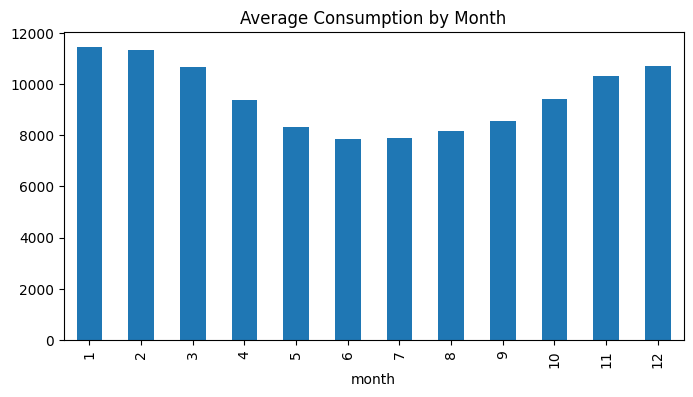

In [14]:
monthly = df.groupby('month')['Electricity_consumption_(MWh)'].mean()

monthly.plot(kind='bar', figsize=(8,4))
plt.title("Average Consumption by Month")
plt.show()

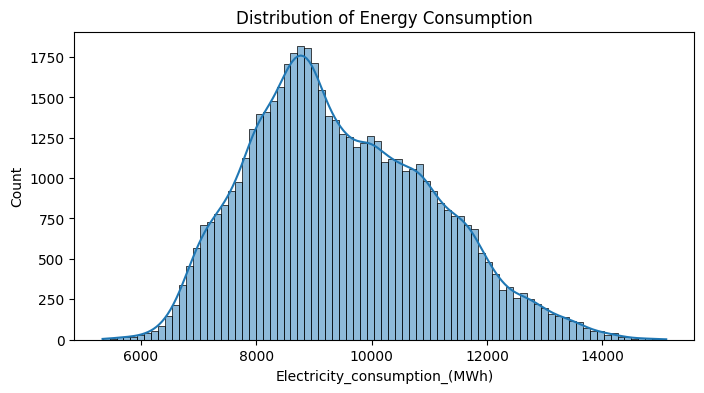

In [15]:
plt.figure(figsize=(8,4))
sns.histplot(df['Electricity_consumption_(MWh)'], kde=True)
plt.title("Distribution of Energy Consumption")
plt.show()


> as we see their is normal distribution and sense of colinearity but cause of my past experince and some personal experience i can say that the robust scaller  still not great cause of some sort of naturall high spikes now i can use trees model and compare them linearity still fails so resudial is more in linear regression

>I selected tree-based ensemble models because hourly energy demand exhibits nonlinear patterns, seasonal effects, and complex feature interactions that violate linear regression assumptions. Tree models capture these relationships automatically and demonstrated superior empirical performance on validation metrics.

# Time Series Validation

## Advantage
- **Prevents data leakage**: We train on past data and test on future data.
- **80% and 20% split for prevention data leakage**

In [16]:
df = df.dropna()

target = 'Electricity_consumption_(MWh)'

cols = [
    'hour_sin','hour_cos',
    'dow_sin','dow_cos',
    'month_sin','month_cos',
    'one_hour_ago',
    'one_day_ago',
    'one_week_ago'
]

X = df[cols]
y = df[target]


split = int(len(df)*0.8)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [17]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

In [18]:
import numpy as np
import optuna
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
import xgboost as xgb

/Users/harshkarnani/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# i used optuna over gridsearch cv cause of the reason or  pruning techqunies it use

In [20]:
study_lgb = optuna.create_study(direction="minimize")

for _ in range(15):

    trial = study_lgb.ask()

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 600),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),
        "max_depth": trial.suggest_int("max_depth", 5, 10),
        "num_leaves": trial.suggest_int("num_leaves", 31, 128),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "random_state": 42,
        "n_jobs": -1,
        "verbose": -1
    }

    rmse_scores = []

    for train_idx, val_idx in tscv.split(X_train):

        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = lgb.LGBMRegressor(**params)

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric="rmse",
            callbacks=[
                lgb.early_stopping(50),
                lgb.log_evaluation(0)
            ]
        )

        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        rmse_scores.append(rmse)

    study_lgb.tell(trial, np.mean(rmse_scores))


best_lgb = lgb.LGBMRegressor(**study_lgb.best_params, n_jobs=-1)
best_lgb.fit(X_train, y_train)

[I 2026-02-26 13:57:15,104] A new study created in memory with name: no-name-bbba789e-7bc0-4232-a581-7e32f7eda725


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[527]	valid_0's rmse: 131.48	valid_0's l2: 17287
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[528]	valid_0's rmse: 107.582	valid_0's l2: 11573.9
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[528]	valid_0's rmse: 88.3579	valid_0's l2: 7807.12
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[527]	valid_0's rmse: 99.0594	valid_0's l2: 9812.76
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[527]	valid_0's rmse: 111.586	valid_0's l2: 12451.4
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[321]	valid_0's rmse: 139.371	valid_0's l2: 19424.4
Training until validation scores don'

LGBMRegressor(colsample_bytree=0.9880125216123837,
              learning_rate=0.06590115099477536, max_depth=9, n_estimators=448,
              n_jobs=-1, num_leaves=34, subsample=0.8903302766786931)

In [25]:
study_gb = optuna.create_study(direction="minimize")

for _ in range(15):

    trial = study_gb.ask()

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 400),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),
        "max_depth": trial.suggest_int("max_depth", 3, 6),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "random_state": 42
    }

    rmse_scores = []

    for train_idx, val_idx in tscv.split(X_train):

        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = GradientBoostingRegressor(**params)

        model.fit(X_tr, y_tr)

        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        rmse_scores.append(rmse)

    study_gb.tell(trial, np.mean(rmse_scores))


best_gb = GradientBoostingRegressor(**study_gb.best_params)
best_gb.fit(X_train, y_train)

[I 2026-02-26 14:02:08,641] A new study created in memory with name: no-name-1c7b473b-a770-4c08-8e89-d6647267030d


GradientBoostingRegressor(learning_rate=0.12402054392417737, max_depth=6,
                          min_samples_leaf=3, min_samples_split=5,
                          n_estimators=337)

In [27]:
study_xgb = optuna.create_study(direction="minimize")

for _ in range(15):

    trial = study_xgb.ask()

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 600),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "random_state": 42,
        "n_jobs": -1,
        "tree_method": "hist"
    }

    rmse_scores = []

    for train_idx, val_idx in tscv.split(X_train):

        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = xgb.XGBRegressor(**params)

        model.fit(X_tr, y_tr)

        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        rmse_scores.append(rmse)

    study_xgb.tell(trial, np.mean(rmse_scores))


best_xgb = xgb.XGBRegressor(**study_xgb.best_params,
                            tree_method="hist",
                            n_jobs=-1)

best_xgb.fit(X_train, y_train)

[I 2026-02-26 14:13:37,935] A new study created in memory with name: no-name-15722bff-1a07-435e-a85f-9d321a89233a


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9454079236729777, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.10908570163044723, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=515, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

> Randomforest is bagging techqunie i.e the data is feed with only one shuffling but in boosting there is shuffle of both rows and coloums so thats but i only applied random forest cause i just wanna see is the spliting is quite enough to get a good ouput or not 

In [28]:
study_rf = optuna.create_study(direction="minimize")

for _ in range(15):  # 🔥 reduce from 30 → 15

    trial = study_rf.ask()

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 500),  # smaller range
        "max_depth": trial.suggest_int("max_depth", 5, 15),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 8),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "max_features": trial.suggest_float("max_features", 0.6, 1.0),
        "random_state": 42,
        "n_jobs": -1
    }

    rmse_scores = []

    for train_idx, val_idx in tscv.split(X_train):

        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = RandomForestRegressor(**params)

        model.fit(X_tr, y_tr)

        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        rmse_scores.append(rmse)

    study_rf.tell(trial, np.mean(rmse_scores))


best_rf = RandomForestRegressor(**study_rf.best_params, n_jobs=-1)
best_rf.fit(X_train, y_train)

[I 2026-02-26 14:14:32,985] A new study created in memory with name: no-name-b79e0965-8713-44cc-a2bf-0fe6ee1deddf


RandomForestRegressor(max_depth=15, max_features=0.9074119677484446,
                      min_samples_leaf=2, min_samples_split=4, n_estimators=500,
                      n_jobs=-1)

In [29]:
models = {
    "LightGBM": best_lgb,
    "XGBoost": best_xgb,
    "GradientBoosting": best_gb,
    "RandomForest": best_rf
}

for name, model in models.items():

    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mape = np.mean(np.abs((y_test - preds) / y_test)) * 100

    print(f"\n{name}")
    print(f"MAE  : {mae:.3f}")
    print(f"RMSE : {rmse:.3f}")
    print(f"MAPE : {mape:.3f}%")


LightGBM
MAE  : 71.268
RMSE : 105.103
MAPE : 0.741%

XGBoost
MAE  : 73.117
RMSE : 108.049
MAPE : 0.756%

GradientBoosting
MAE  : 72.565
RMSE : 106.938
MAPE : 0.753%

RandomForest
MAE  : 80.749
RMSE : 115.924
MAPE : 0.831%


> as we can see lightbgm performe well but if i have more ram or computation power i would tune more hyperparamter but as outstand i would say lightbgm can flexible when their is leaf growth sometimes better then xg when we do time series that why